## Setup (for Colab)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd drive/MyDrive/ai-for-finance/notebooks/

## Description

Los algoritmos de riesgo de credito son algoritmos que permiten evaluar el riesgo de un prestamo, es decir, la probabilidad de que un cliente no pague su deuda.

En este ejemplo vamos a trabajar con un dataset de Kaggle que contiene datos de prestamos de un banco.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


In [3]:
sns.set_style("whitegrid")

In [4]:
train_df = pd.read_csv('../datasets/cs-training.csv').drop(['Unnamed: 0'], axis=1)

### EDA (Exploratory Data Analysis)

In [5]:
train_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [6]:
train_df['SeriousDlqin2yrs'].value_counts()

SeriousDlqin2yrs
0    139974
1     10026
Name: count, dtype: int64

In [7]:
#get the number of missing data points per column for train
missing_values_count_train = train_df.isnull().sum()
missing_values_count_train

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [8]:
attributes= [
    'RevolvingUtilizationOfUnsecuredLines', 
    'age',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate',
    'DebtRatio', 
    'MonthlyIncome',
    'NumberOfOpenCreditLinesAndLoans', 
    'NumberRealEstateLoansOrLines', 
    'NumberOfDependents',
]

In [9]:
train_df = train_df[['SeriousDlqin2yrs'] + attributes]


In [10]:
train_df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,0.240387,0.265973,353.005076,6.670221e+03,8.452760,1.018240,0.757222
std,0.249746,249.755371,14.771866,4.192781,4.155179,4.169304,2037.818523,1.438467e+04,5.145951,1.129771,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.000000,0.000000,0.366508,5.400000e+03,8.000000,1.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.000000,0.000000,0.868254,8.249000e+03,11.000000,2.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,98.000000,98.000000,329664.000000,3.008750e+06,58.000000,54.000000,20.000000


Parece que 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse' y 'NumberOfTimes90DaysLate' eran una característica que se dividió en tres.<br><br> Después de ver la matriz de correlación, podemos observar que las características 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse' y 'NumberOfTimes90DaysLate' están altamente correlacionadas entre sí.

In [11]:
train_df[['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate']].corr()*100

,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate
NumberOfTime30-59DaysPastDueNotWorse,100.000000,98.700545,98.360268
NumberOfTime60-89DaysPastDueNotWorse,98.700545,100.000000,99.279618
NumberOfTimes90DaysLate,98.360268,99.279618,100.000000


In [12]:
train_df['SeriousDlqin2yrs'][
    (train_df['NumberOfTime30-59DaysPastDueNotWorse'] == 98) | 
    (train_df['NumberOfTime60-89DaysPastDueNotWorse'] == 98) | 
    (train_df['NumberOfTimes90DaysLate'] == 98)
    ].value_counts()

SeriousDlqin2yrs
1    143
0    121
Name: count, dtype: int64

### Plot data distribution

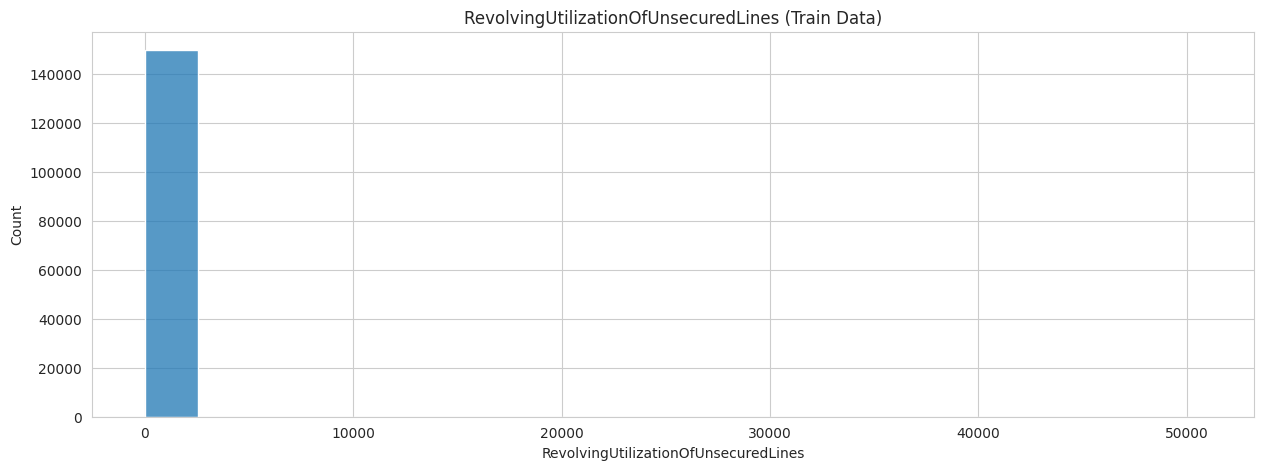

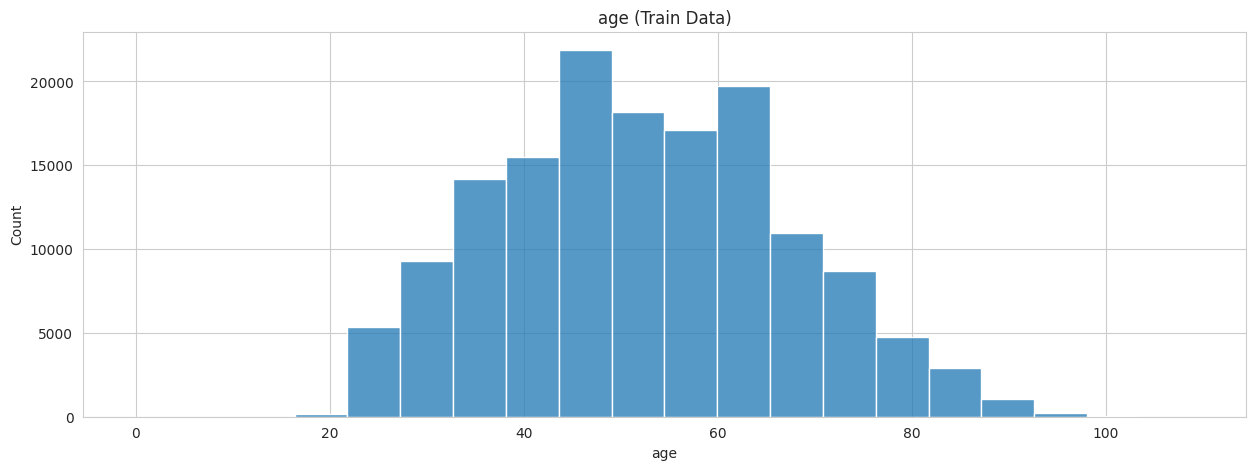

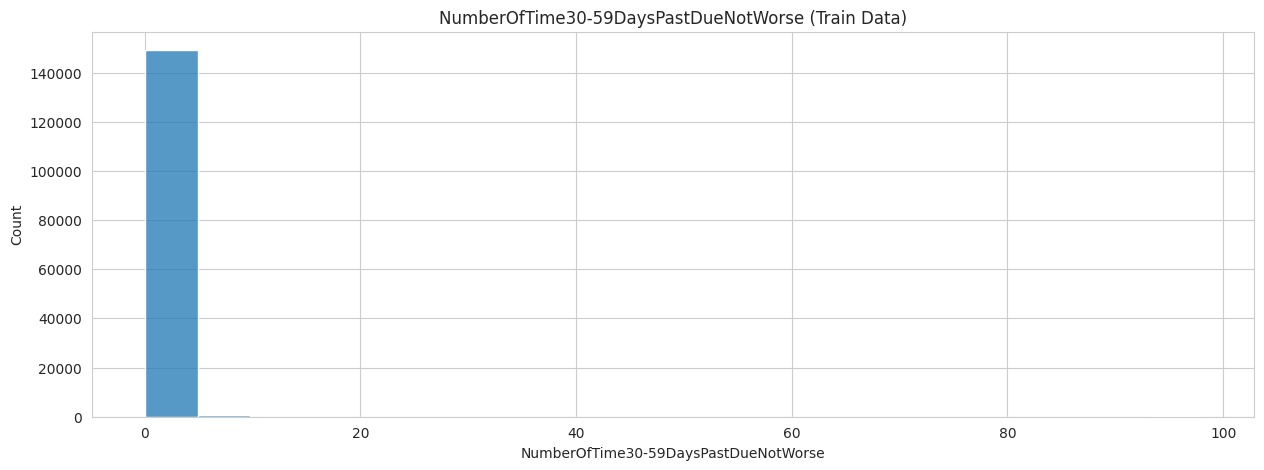

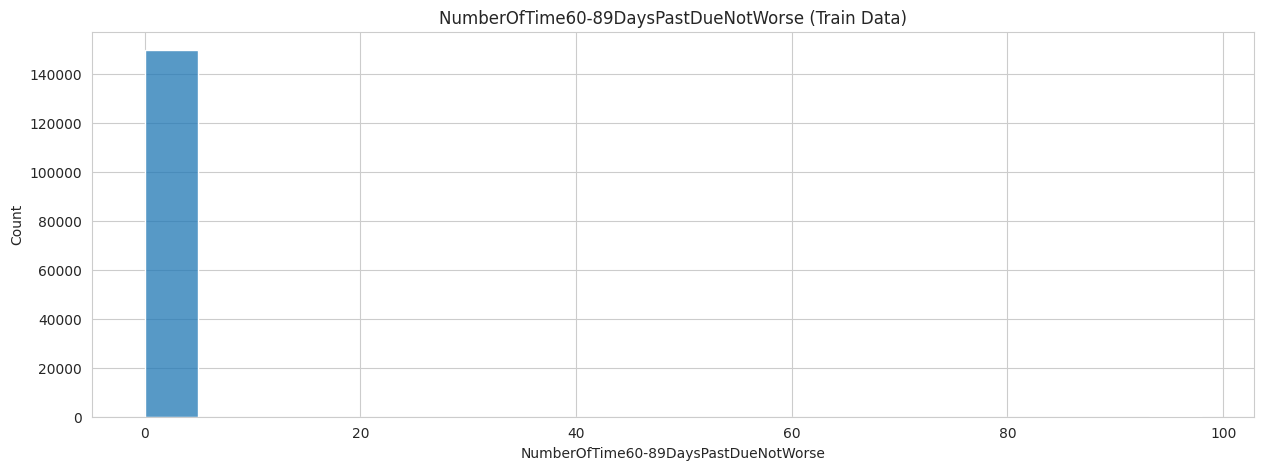

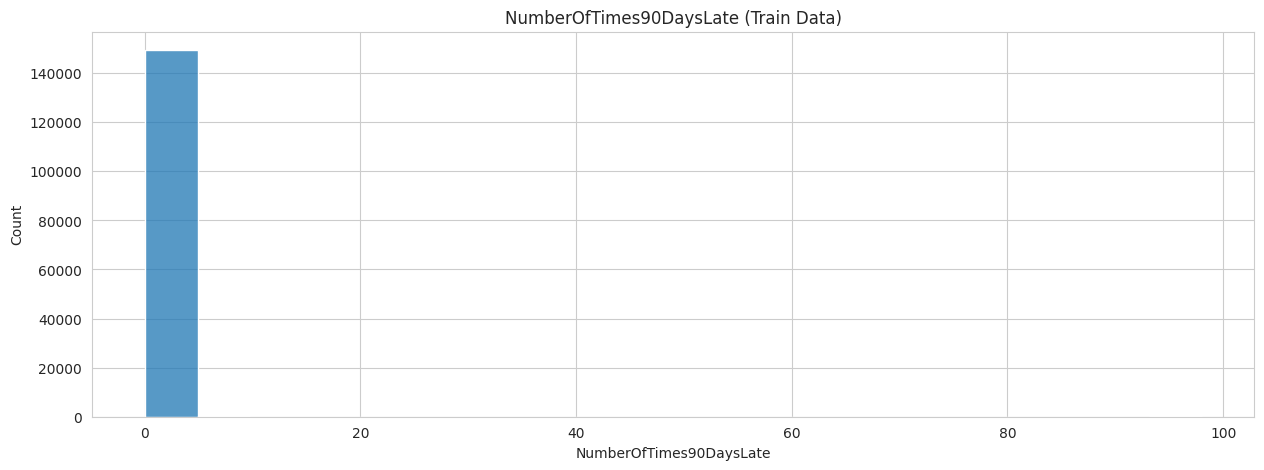

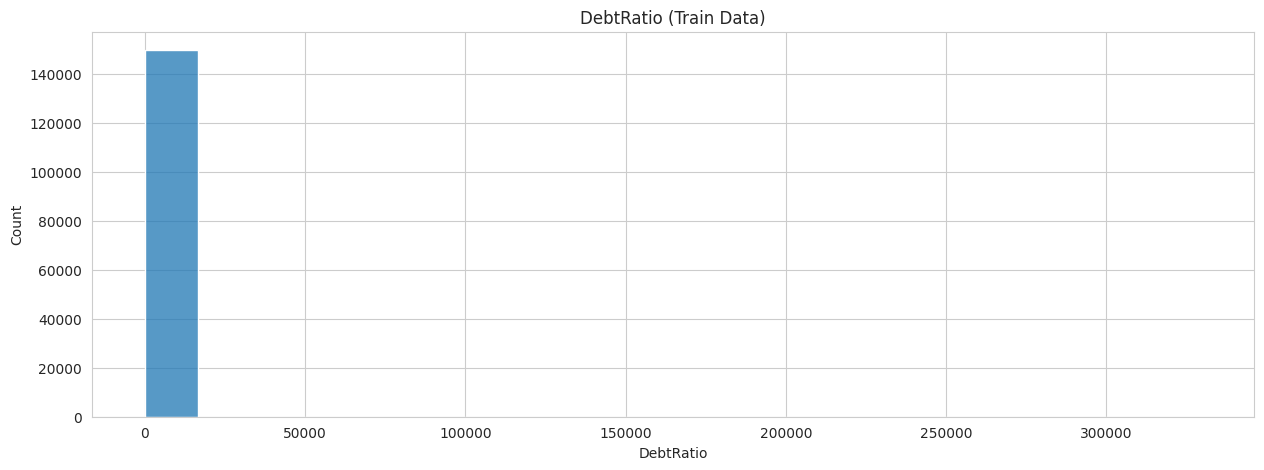

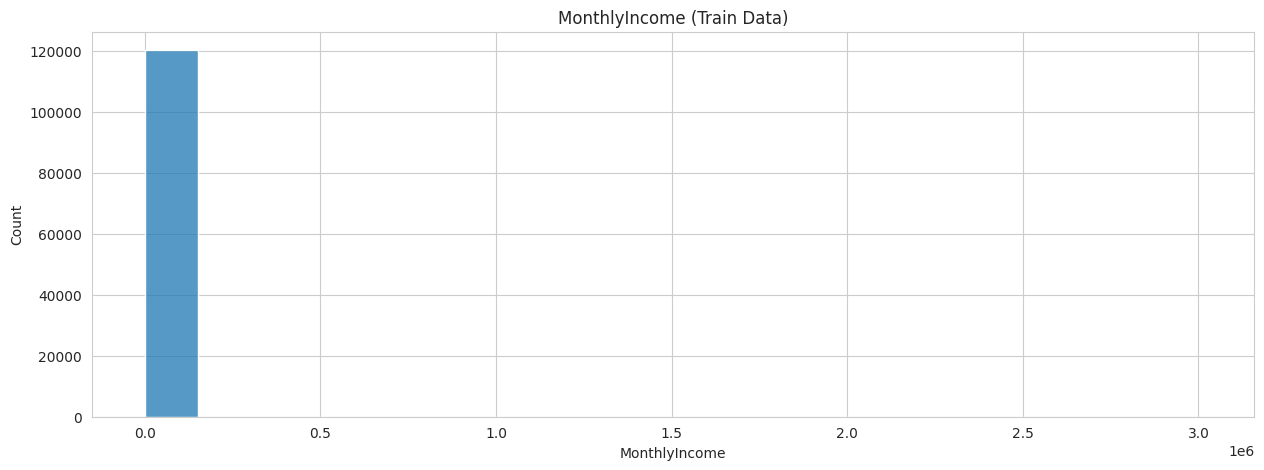

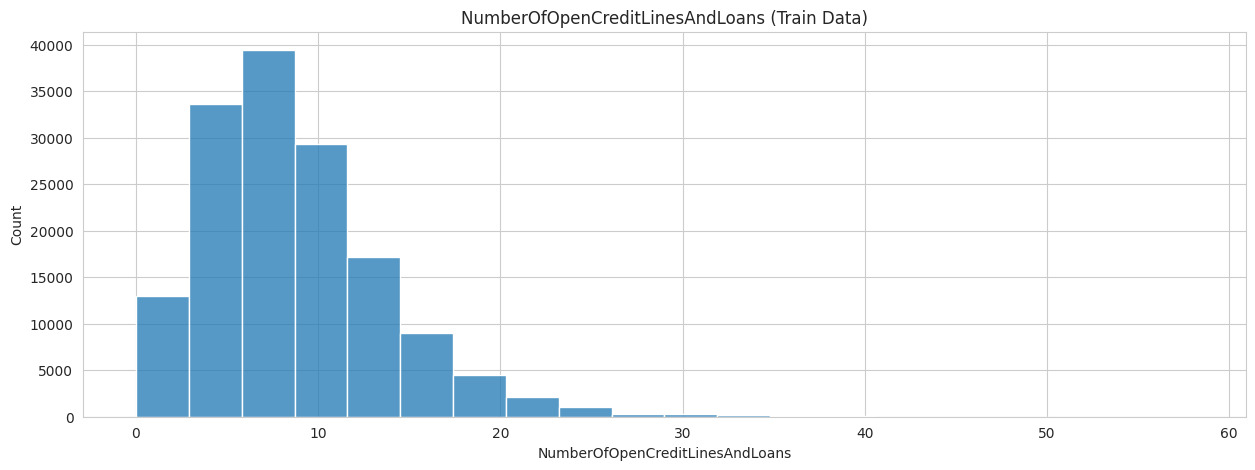

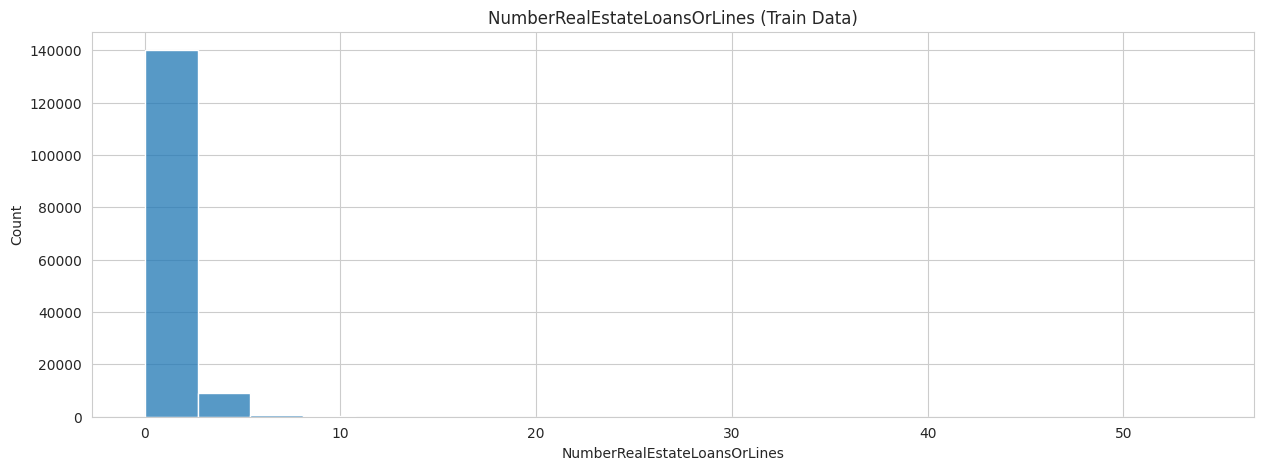

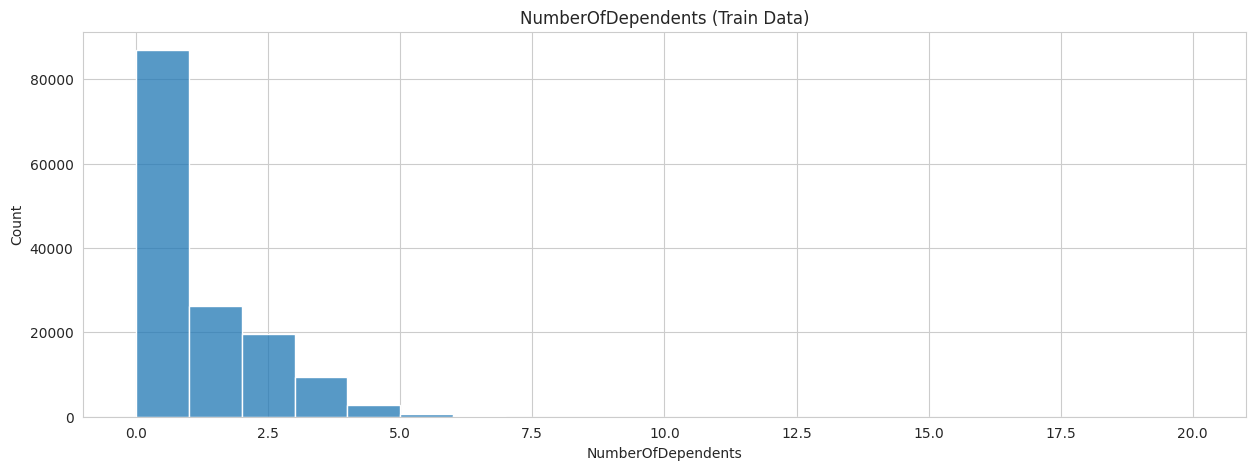

In [13]:
for attribute in attributes:
    fig, axes = plt.subplots(1, figsize=(15, 5))
    axes.set_title(attribute+' (Train Data)')
    # sns.histplot(train_df, x=attribute, ax=axes[0], bins=20, kde=True)
    sns.histplot(train_df, x=attribute, ax=axes, bins=20)

## Outliers processing

In [14]:
def normalizer(x, df):
    upper_boundary = df[x].mean()+2*df[x].std()
    lower_boundary = df[x].mean()-2*df[x].std()
    max_att = df[x].max()
    min_att = df[x].min()
    return {
        'Attribute': x, 
        'upper_boundary': upper_boundary, 
        'lower_boundary': lower_boundary, 
        'max_att':max_att, 
        'min_att':min_att 
    }

In [15]:
train_limits_df = pd.DataFrame([normalizer(x, train_df) for x in attributes])
train_limits_df

,Attribute,upper_boundary,lower_boundary,max_att,min_att
0,RevolvingUtilizationOfUnsecuredLines,505.559179,-493.462303,50708.0,0.0
1,age,81.838938,22.751475,109.0,0.0
2,NumberOfTime30-59DaysPastDueNotWorse,8.806596,-7.964529,98.0,0.0
3,NumberOfTime60-89DaysPastDueNotWorse,8.550746,-8.069972,98.0,0.0
4,NumberOfTimes90DaysLate,8.604581,-8.072634,98.0,0.0
5,DebtRatio,4428.642122,-3722.631971,329664.0,0.0
6,MonthlyIncome,35439.569668,-22099.127193,3008750.0,0.0
7,NumberOfOpenCreditLinesAndLoans,18.744662,-1.839142,58.0,0.0
8,NumberRealEstateLoansOrLines,3.277782,-1.241302,54.0,0.0
9,NumberOfDependents,2.987394,-1.472950,20.0,0.0


In [16]:
for index, row in train_limits_df.iterrows():
    train_df.loc[:, row['Attribute']][(train_df[row['Attribute']] > row['upper_boundary'])] = row['upper_boundary']
    train_df.loc[:, row['Attribute']][(train_df[row['Attribute']] < row['lower_boundary'])] = row['lower_boundary']


/tmp/ipykernel_10805/1724251982.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, row['Attribute']][(train_df[row['Attribute']] < row['lower_boundary'])] = row['lower_boundary']
/tmp/ipykernel_10805/1724251982.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, row['Attribute']][(train_df[row['Attribute']] < row['lower_boundary'])] = row['lower_boundary']
/tmp/ipykernel_10805/1724251982.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [17]:
train_df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,120269.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,1.051995,52.180614,0.261014,0.080022,0.105144,310.016729,6421.737347,8.282302,0.975016,0.720172
std,0.249746,18.959179,14.492167,0.783982,0.487127,0.593999,874.880551,4729.484112,4.629337,0.937247,1.005409
min,0.000000,0.000000,22.751475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.000000,0.000000,0.175074,3400.000000,5.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.000000,0.000000,0.366508,5400.000000,8.000000,1.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.000000,0.000000,0.868254,8249.000000,11.000000,2.000000,1.000000
max,1.000000,505.559179,81.838938,8.806596,8.550746,8.604581,4428.642122,35439.569668,18.744662,3.277782,2.987394


### Train model

In [18]:
X = train_df.drop(['SeriousDlqin2yrs'], axis=1)
y = train_df['SeriousDlqin2yrs']

In [19]:
# imputing missing values
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X)

X = pd.DataFrame(imp.transform(X), columns=X.columns)

missing_values_count_train = X.isnull().sum()
missing_values_count_train

RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfTimes90DaysLate                 0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberRealEstateLoansOrLines            0
NumberOfDependents                      0
dtype: int64

In [20]:
scaler = RobustScaler()
X = scaler.fit_transform(X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [22]:
dumb_auc = roc_auc_score(y_test, np.zeros(len(y_test)))
dumb_auc

0.5

In [23]:
# List of models to try
model_params = {
    RandomForestClassifier(): {'n_estimators': [100, 150], 'max_depth': [None, 10]},
    GradientBoostingClassifier(): {'n_estimators': [100, 150], 'learning_rate': [0.01, 0.1, 0.2]},
    LogisticRegression(solver='liblinear', max_iter=1000): {'C': [0.001, 0.01, 0.1, 1, 10]},
}

best_auc = 0
best_model = None
best_model_metrics = {}

# Hyperparameter tuning and model selection
for model, params in model_params.items():
    
    # grid_search = GridSearchCV(model, param_grid=params, cv=3, scoring='roc_auc')
    grid_search = GridSearchCV(model, param_grid=params, cv=2, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    
    best_estimator = grid_search.best_estimator_
    y_pred = best_estimator.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_pred)

    
    # Calculate other classification metrics
    classification_rep = classification_report(y_test, y_pred.round(), target_names=['Negative', 'Positive'], output_dict=True)

    # Store metrics for the best model
    model_metrics = {
        'auc': auc,
        'precision': classification_rep['Positive']['precision'],
        'recall': classification_rep['Positive']['recall'],
        'f1': classification_rep['Positive']['f1-score'],
    }
    
    model_name = model.__class__.__name__
    
    print(f'Best parameters for {model_name}: {grid_search.best_params_}')
    print(f"model metrics: {model_metrics}")
    
    best_model_metrics[model_name] = model_metrics
    
    if auc > best_auc:
        best_auc = auc
        best_model = best_estimator

Best parameters for RandomForestClassifier: {'max_depth': 10, 'n_estimators': 100}
model metrics: {'auc': 0.8620317569232571, 'precision': 0.6014492753623188, 'recall': 0.16895674300254454, 'f1': 0.26380611839491463}
Best parameters for GradientBoostingClassifier: {'learning_rate': 0.1, 'n_estimators': 150}
model metrics: {'auc': 0.8618432611725346, 'precision': 0.5609022556390978, 'recall': 0.18982188295165395, 'f1': 0.28365019011406845}
Best parameters for LogisticRegression: {'C': 0.01}
model metrics: {'auc': 0.8024677441093944, 'precision': 0.5423280423280423, 'recall': 0.10432569974554708, 'f1': 0.1749893299189074}
